# TensorFlow Tutorial #03-C
# Keras API

by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)
/ [GitHub](https://github.com/Hvass-Labs/TensorFlow-Tutorials) / [Videos on YouTube](https://www.youtube.com/playlist?list=PL9Hr9sNUjfsmEu1ZniY0XpHSzl5uihcXZ)

中文翻译[ZhouGeorge](https://github.com/ZhouGeorge)/[GitHub](https://github.com/ZhouGeorge/TensorFlow-Tutorials)

## 介绍

教程#02展示了如何利用TensorFlow去实现卷积神经网络。我们建立了一些帮助函数去生成网络中的层。拥有一个好的高级API是很重要的，因为它使实现复杂模型变得更加容易，并且降低了错误的风险。

在TensorFlow中有一些辅助构筑网络的API可以利用：PrettyTensor (教程 #03)， Layers API (教程 #03-B)，等等。但是他们从来没有被真正地完成过，而且现在它们似乎或多或少被他们的开发人员抛弃了

本教程是关于Keras的API，它有有非常好的文档，完成度很高并且在持续的开发中。Keras很有可能是未来TensorFlow的标准API，因此建议您使用它而不是其他API。

你应该读一读Keras的作者写的一篇关于他的API设计理念的[blog-post](https://blog.keras.io/user-experience-design-for-apis.html) 。

## 流程图

下面的图表直接展示了之后实现的卷积神经网络中数据的传递。关于卷积的详细描述请看教程#2。

这里有2个卷积层，每层之后采用最大池化进行下采样（在图中没有显示出来），之后接着两个全连接层以softmax-classifier结束。


![Flowchart](images/02_network_flowchart.png)

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import math

我们需要从Keras中引用一些内容。注意这些长的引用声明。

In [2]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import InputLayer, Input
from tensorflow.python.keras.layers import Reshape, MaxPooling2D
from tensorflow.python.keras.layers import Conv2D, Dense, Flatten

This was developed using Python 3.6 (Anaconda) and TensorFlow version:

In [3]:
tf.__version__

'1.6.0'

In [4]:
tf.keras.__version__

'2.1.3-tf'

## 载入数据

MNIST数据集大约12MB，如果没在给定路径中找到就会自动下载。

In [5]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('data/MNIST/', one_hot=True)

Extracting data/MNIST/train-images-idx3-ubyte.gz
Extracting data/MNIST/train-labels-idx1-ubyte.gz
Extracting data/MNIST/t10k-images-idx3-ubyte.gz
Extracting data/MNIST/t10k-labels-idx1-ubyte.gz


现在已经载入了MNIST数据集，它由70,000张图像和对应的标签（比如图像的类别）组成。数据集分成三份互相独立的子集。我们在教程中只用训练集和测试集。

In [6]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(data.test.labels)))
print("- Validation-set:\t{}".format(len(data.validation.labels)))

Size of:
- Training-set:		55000
- Test-set:		10000
- Validation-set:	5000


类型标签使用One-Hot编码，这意外每个标签是长为10的向量，除了一个元素之外，其他的都为零。这个元素的索引就是类别的数字，即相应图片中画的数字。我们也需要测试数据集类别数字的整型值，用下面的方法来计算。

In [7]:
data.test.cls = np.argmax(data.test.labels, axis=1)

## 数据维度

在下面的源码中，有很多地方用到了数据维度。它们只在一个地方定义，因此我们可以在代码中使用这些数字而不是直接写数字。

In [8]:
#我们知道MNIST图像每个维度有28个像素
img_size = 28

#图片以一维的方式存储
img_size_flat = img_size * img_size

# 确定图片的高和宽用于之后重塑数组
# 用于画图
img_shape = (img_size, img_size)

#具有高，宽和深度的元组用于重塑数组
#用于Keras中
img_shape_full = (img_size, img_size, 1)

#颜色通道数目：灰度图只有一个通道
num_channels = 1

#类的数量，一类代表0-9中的相应数字
num_classes = 10

###  用来绘制图片的帮助函数

这个函数用来在3x3的栅格中画9张图像，然后在每张图像下面写出真实类别和预测类别。

In [9]:
def plot_images(images, cls_true, cls_pred=None):
    assert len(images) == len(cls_true) == 9
    #创建3x3的子图
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        #画图
        ax.imshow(images[i].reshape(img_shape), cmap='binary')

        #显示正确和预测的类
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        #在X轴显示正确的标签
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    #确保图被正确显示在一个单元里
    plt.show()

### 绘制几张图像来看看数据是否正确

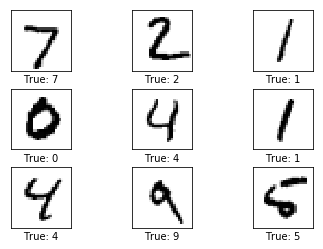

In [10]:
#从test-set中获取前10张图
images = data.test.images[0:9]

#获得上图对应的类别
cls_true = data.test.cls[0:9]

#利用我们helper-fuction函数画出图片和标签
plot_images(images=images, cls_true=cls_true)

### 用来绘制错误样本的帮助函数

函数用来绘制测试集中被误分类的样本。

In [11]:
def plot_example_errors(cls_pred):
    #cls_pred是在test-set中所有图片预测类别的数组

    #布尔数组中true表示对应编号预测的结果不正确的
    incorrect = (cls_pred != data.test.cls)

    #从test-set中获取被错误分类的图片
    images = data.test.images[incorrect]
    
    #获得这些被错误预测图片被预测的类
    cls_pred = cls_pred[incorrect]

    #获得这些图片正确的类
    cls_true = data.test.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

## PrettyTensor API

这是教程#03中利用PrettyTensor API实现卷积网络的过程，放在这为了与下面利用Keras实现的过程做比较。

In [12]:
if False:
    x_pretty = pt.wrap(x_image)

    with pt.defaults_scope(activation_fn=tf.nn.relu):
        y_pred, loss = x_pretty.\
            conv2d(kernel=5, depth=16, name='layer_conv1').\
            max_pool(kernel=2, stride=2).\
            conv2d(kernel=5, depth=36, name='layer_conv2').\
            max_pool(kernel=2, stride=2).\
            flatten().\
            fully_connected(size=128, name='layer_fc1').\
            softmax_classifier(num_classes=num_classes, labels=y_true)

## 顺序模型（Sequential Model）

Keras API有两种模式来搭建网络结构。最简单的方式是顺序模型（Sequential Model），它只允许按顺序添加层。

In [13]:
#开始构建Keras顺序模型。
model = Sequential()

#添加输入层，类似于TensorFlow中的feed_dict
#注意，输入的形状必须是一个包含图像大小的元组。
model.add(InputLayer(input_shape=(img_size_flat,)))

#输入是一个包含784个元素的扁平数组
#但是卷积层期望图片的形状是(28, 28, 1)
model.add(Reshape(img_shape_full))

#第一个卷积层，包含Relu激活函数与最大池化
model.add(Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
                 activation='relu', name='layer_conv1'))
model.add(MaxPooling2D(pool_size=2, strides=2))

#第二个卷积层，包含Relu激活函数与最大池化
model.add(Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
                 activation='relu', name='layer_conv2'))
model.add(MaxPooling2D(pool_size=2, strides=2))

#将卷积层4维的输出展平成2维，用于输入到全连接层
model.add(Flatten())

#第一个全连接层，包含ReLU激活函数
model.add(Dense(128, activation='relu'))

#最后的全连接层，包含softmax激活函数用于分类
model.add(Dense(num_classes, activation='softmax'))

### 模型编译

神经网络已经被定义好，但还需要增加损失函数，优化器和评价指标才能算完成，这被称为Keras的模型“编译(compilation)”。

我们可以利用字符串来定义优化器，或者如果我们想要对其参数进行更多的控制那么我们需要实例化一个对象。比如说，我们可以设置学习率。

In [14]:
from tensorflow.python.keras.optimizers import Adam

optimizer = Adam(lr=1e-3)

对于像MNIST这样有10个可能的类别的分类问题，我们需要用到 `categorical_crossentropy`损失函数。我们感兴趣的性能指标（metric）是分类精度。

In [15]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### 训练

现在模型已经定义了损失函数和优化器，我们可以训练它。这个函数接受numpy-array，指定批的大小进行运算，训练epochs次。一个epoch是表示用了整个训练集数据一次。所以10个epochs表示我们会在整个训练集上随机重复10次。


In [16]:
model.fit(x=data.train.images,
          y=data.train.labels,
          epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================]55000/55000 [==============================] - 9s 166us/step - loss: 0.2118 - acc: 0.9396



### 评估

现在模型已经被训练好了，我们可以在测试集中测试它的性能。这也是使用numpy-array作为输入。

In [17]:
result = model.evaluate(x=data.test.images,
                        y=data.test.labels)

10000/10000 [==============================]10000/10000 [==============================] - 1s 79us/step



我们可以打印测试集的所有性能指标。

In [18]:
for name, value in zip(model.metrics_names, result):
    print(name, value)

loss 0.0586094780088
acc 0.9797


或者我们只打印分类精度。

In [19]:
print("{0}: {1:.2%}".format(model.metrics_names[1], result[1]))

acc: 97.97%


### 预测

我们还可以预测新图像的分类，我们将用测试集里的一些照片，你也可以用你自己的图片放入这个numpy数组中来代替。

In [20]:
images = data.test.images[0:9]

这是这些图片的正确类别。我们在画图的时候需要用到它。

In [21]:
cls_true = data.test.cls[0:9]

获得预测的结果为一个独热编码数组。

In [22]:
y_pred = model.predict(x=images)

获得整数形的预测类别。

In [23]:
cls_pred = np.argmax(y_pred,axis=1)

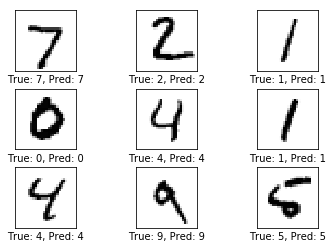

In [24]:
plot_images(images=images,
            cls_true=cls_true,
            cls_pred=cls_pred)

### 错误分类图片的例子

我们可以画出一些在测试集中被错误分类的例子。

首先我们获得测试集中所有图片的预测类别。

In [25]:
y_pred = model.predict(x=data.test.images)

然后我们将预测的类别由入独热编码转换成整数形式。

In [26]:
cls_pred = np.argmax(y_pred,axis=1)

画出一些错误分类的图片。

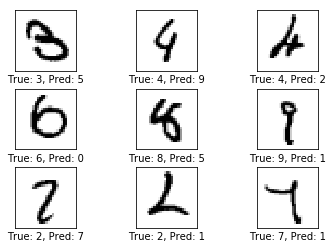

In [27]:
plot_example_errors(cls_pred)

## 函数式模型(Functional Model)

Keras API的另一种搭建网络的方式(Functional Model)。乍一看，这可能让人困惑，因为每次对Keras API的调用都会创建并返回一个自身可调用的实例。我们不清楚它是个函数还是一个对象，但是我们可以像用函数一样调用它。这使我们能够构建比顺序模型更复杂的计算图。

In [28]:
#添加输入层，类似于TensorFlow中的feed_dict
#注意，输入的形状必须是一个包含图像大小的元组。
inputs = Input(shape=(img_size_flat,))

#用于构建神经网络的变量。
net = inputs

#输入是一个包含784个元素的扁平数组
#但是卷积层期望图片的形状是(28, 28, 1)
net = Reshape(img_shape_full)(net)

#第一个卷积层，包含Relu激活函数与最大池化
net = Conv2D(kernel_size=5, strides=1, filters=16, padding='same',
             activation='relu', name='layer_conv1')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

#第二个卷积层，包含Relu激活函数与最大池化
net = Conv2D(kernel_size=5, strides=1, filters=36, padding='same',
             activation='relu', name='layer_conv2')(net)
net = MaxPooling2D(pool_size=2, strides=2)(net)

#将卷积层4维的输出展平成2维，用于输入到全连接层
net = Flatten()(net)

#第一个全连接层，包含ReLU激活函数
net = Dense(128, activation='relu')(net)

#最后的全连接层，包含softmax激活函数用于分类
net = Dense(num_classes, activation='softmax')(net)

#神经网络的输出
outputs = net

### 模型编译

我们已经定义了模型的架构，包含了它的输入和输出。我们现在必须创建一个Keras的模型并编译它的损失函数和优化器，这样它就可以被训练了。

In [29]:
from tensorflow.python.keras.models import Model

创建一个新的Keras函数式模型的实例。我们写入我们构筑的卷积神经网络的输入和输出。

In [30]:
model2 = Model(inputs=inputs, outputs=outputs)

用`rmsprop`优化器和多类别的损失函数去完成Keras模型的编译。这里我们只对分类精度指标感兴趣，你可以在这里(metrics)使用一个指标列表。

In [31]:
model2.compile(optimizer='rmsprop',
               loss='categorical_crossentropy',
               metrics=['accuracy'])

### 训练

模型已经被定义和编译，所以我们可以用`fit()`函数去训练它，这与顺序模型的训练方法一致。这里也是将numpy-array作为输入。

In [32]:
model2.fit(x=data.train.images,
           y=data.train.labels,
           epochs=1, batch_size=128)

Epoch 1/1
55000/55000 [==============================]55000/55000 [==============================] - 4s 72us/step - loss: 0.1946 - acc: 0.9397



### 评价
模型一旦被训练好，我们可以用测试集去评价它的表现，这里的用法与顺序模型一致。

In [33]:
result = model2.evaluate(x=data.test.images,
                         y=data.test.labels)

10000/10000 [==============================]10000/10000 [==============================] - 1s 77us/step



The result is a list of values, containing the loss-value and all the metrics we defined when we compiled the model. Note that 'accuracy' is now called 'acc' which is a small inconsistency.
结果是一个列表，里面包含我们在给模型定义时的损失和评价指标。注意，这里有一点区别，“accuracy”现在被称为“acc”。

In [34]:
for name, value in zip(model2.metrics_names, result):
    print(name, value)

loss 0.0518957972745
acc 0.9828


我们也可以按百分比输出分类的正确率

In [35]:
print("{0}: {1:.2%}".format(model2.metrics_names[1], result[1]))

acc: 98.28%


### 错误分类图片的案例

我们可以从测试集中画出一些错误分类的图片。

首先，我们得到了测试集中所有图像的预测类：

In [36]:
y_pred = model2.predict(x=data.test.images)

然后我们将预测的类数从一个独热编码的数组转换成整数。

In [37]:
cls_pred = np.argmax(y_pred, axis=1)

画一些错误分类的图片。

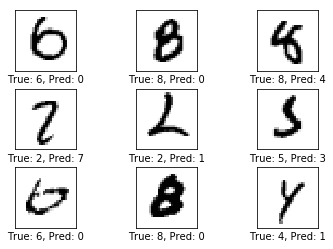

In [38]:
plot_example_errors(cls_pred)

## 保存及加载模型

注意：你需要先安装`h5py`

教程#04中有用原始的Tensorflow代码来保存和加载模型的权重。这不是一个方便的API！
幸运的是，Keras让这个过程更简单。

下面是我们想要保存Keras模型的路径。

In [39]:
path_model = 'model.keras'

保存训练好的Keras模型的权重只需要调用一个函数。

In [40]:
model2.save(path_model)

当我们不再需要用到这个模型时可以，可以从内存中删除这个它。

In [41]:
del model2

我需要引入Keras的函数去加载模型。

In [42]:
from tensorflow.python.keras.models import load_model

加载模型只需要调用一个函数.

In [43]:
model3 = load_model(path_model)

然后我们可以继续使用这个模型去预测，我们从测试集中获得前9张图片和它们正确的类别。

In [44]:
images = data.test.images[0:9]

In [45]:
cls_true = data.test.cls[0:9]

我们用这个加载的模型去预测这些图片的类别。

In [46]:
y_pred = model3.predict(x=images)

获得类别的整数形式。

In [47]:
cls_pred = np.argmax(y_pred, axis=1)

画出这些图片正确的类别和预测的类别。

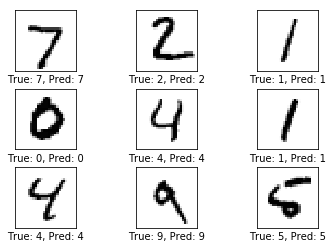

In [48]:
plot_images(images=images,
            cls_pred=cls_pred,
            cls_true=cls_true)

## 每层权重和输出的可视化

### 用于绘制卷积层权重的辅助函数

In [49]:
def plot_conv_weights(weights, input_channel=0):
    #获取权重中最大值和最小值。它们被用作调整图片中权重显示的颜色强度
    #可以显示出不同权重大小之间的比较
    w_min = np.min(weights)
    w_max = np.max(weights)

    #在卷积层中用的滤波器的数目
    num_filters = weights.shape[3]

    #图的网格数
    #对滤波器数目开方并向上取整数
    num_grids = math.ceil(math.sqrt(num_filters))
    
     #按子图的网格数创建图
    fig, axes = plt.subplots(num_grids, num_grids)

    #画出所有滤波器权重
    for i, ax in enumerate(axes.flat):
        #只画出有效的滤波器权重
        if i<num_filters:
            #获取输入通道的第i个过滤器的权重
            #有关于这4维的张量格式，请参照于new_conv_layer()
            img = weights[:, :, input_channel, i]

            #画出图像
            ax.imshow(img, vmin=w_min, vmax=w_max,
                      interpolation='nearest', cmap='seismic')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 获取层结构

Keras有一个简单的方法去列出模型的层结构。

In [50]:
model3.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 784)               0         
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
layer_conv1 (Conv2D)         (None, 28, 28, 16)        416       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
layer_conv2 (Conv2D)         (None, 14, 14, 36)        14436     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 36)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 1764)              0         
__________

我们计算索引去获得我们想要的层。

输入层（input-layer）的索引是0。

In [51]:
layer_input = model3.layers[0]

第一个卷积层的索引是2.

In [52]:
layer_conv1 = model3.layers[2]
layer_conv1

第二个卷积层的索引是4

In [53]:
layer_conv2 = model3.layers[4]

### 卷积层的权重是

现在我们有了卷积层，可以轻松的获得它们的权重。

In [54]:
weights_conv1 = layer_conv1.get_weights()[0]

我们得到一个4维的张量

In [55]:
weights_conv1.shape

(5, 5, 1, 16)

用辅助函数画出权重。

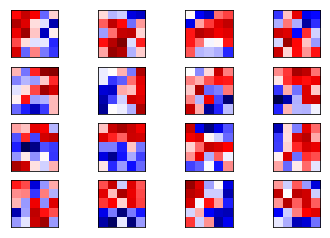

In [56]:
plot_conv_weights(weights=weights_conv1, input_channel=0)

我们也可以获得第二个卷积层的权重并画出它们。

In [57]:
weights_conv2 = layer_conv2.get_weights()[0]

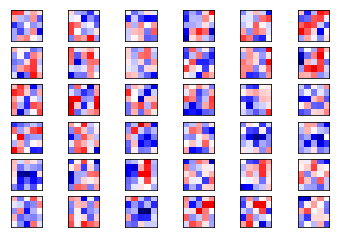

In [58]:
plot_conv_weights(weights=weights_conv2, input_channel=0)

### 绘制卷积层输出图像的辅助函数

In [59]:
def plot_conv_output(values):
    #在卷积层中用的滤波器的数目
    num_filters = values.shape[3]

    #图的网格数
    #对滤波器数目开方并向上取整数
    num_grids = math.ceil(math.sqrt(num_filters))
    
    #按子图的网格数创建图
    fig, axes = plt.subplots(num_grids, num_grids)

    #画出所有滤波器输出的图像
    for i, ax in enumerate(axes.flat):
         #只画有效的滤波器的图像
        if i<num_filters:
            #获取使用“i”过滤器的输出图像
            img = values[0, :, :, i]

            #画出图像
            ax.imshow(img, interpolation='nearest', cmap='binary')
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

### 输入图像

用辅助函数画一张图像

In [60]:
def plot_image(image):
    plt.imshow(image.reshape(img_shape),
               interpolation='nearest',
               cmap='binary')

    plt.show()

从测试集中绘制一个图像，它将作为下面的示例使用。

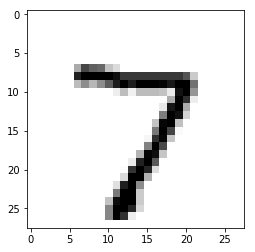

In [61]:
image1 = data.test.images[0]
plot_image(image1)

###  卷积层的输出--方法1

在Kears模型中获取一个层的输出有不同的方法。这个方法使用一个所谓的k函数，它将Keras模型的一部分变成一个函数。

In [62]:
from tensorflow.python.keras import backend as K

In [63]:
output_conv1 = K.function(inputs=[layer_input.input],
                          outputs=[layer_conv1.output])

然后我们可以将图片传入这个函数。注意，图像被包装在两个列中，因为该函数需要这样维度的数组输入。同样的，这个函数返回一个同样维度的数组，数组维度比我们需要的要多出一个，所以我们只需要取第一维。

In [64]:
layer_output1 = output_conv1([[image1]])[0]
layer_output1.shape

(1, 28, 28, 16)

我们可以画出全部16个通道的卷积层输出。

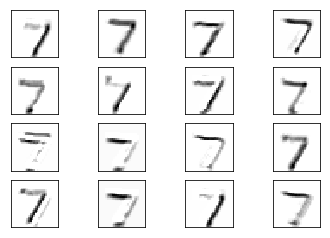

In [65]:
plot_conv_output(values=layer_output1)

### 卷积层的输出--方法2

Keras有另一种方法模型中层的输出。我们可以创建另一个与原模型具有同样输入，而输出层用卷积层代替的函数形模型。

In [66]:
output_conv2 = Model(inputs=layer_input.input,
                     outputs=layer_conv2.output)

这样就创建了一个新的模型对象，我们可以在上面调用典型的Keras函数。为了得到卷积层的输出，我们用输入图像来调用`predict()`函数。

In [67]:
layer_output2 = output_conv2.predict(np.array([image1]))
layer_output2.shape

(1, 14, 14, 36)

然后我们可以画出36个卷积层通道的输出结果。

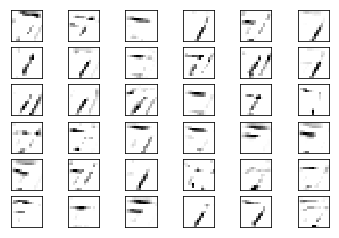

In [68]:
plot_conv_output(values=layer_output2)

## 总结

这份教程展示了如何利用Keras API构建卷积神经网络。到目前为止，Keras是TensorFlow中最完整、最好的API。

这份教程也展示如何利用Keras去保存模型、加载模型、获得卷积层权重和卷积层的输出。

Keras相当好用并且一直在提升，看起来它会在未来成为TensorFlow的标准API，所以我们建议你去用Keras。

## 练习

这里有些练习的建议可以帮助你去提高Tensorflow的技巧。为了能正确的使用TensorFlow，实践经验是很重要的。

在你对这个Notebook进行修改之前，可能需要先备份一下。

* 训练更多的epochs。看看这会不会提升分类的准确率？
* 把一些层的把激活函数改成sigmoid。
* 你能找到一种简单的方法来改变所有层的激活函数吗？
* 画出最大池化层的输出来替代卷积层的输出。
* 在卷积层中用stride=2的卷积来替代2X2 max-pooling，分类精度有差异吗？如果你一次又一次地优化它呢？，差异是任意变化的，你又要如何去衡量这个差异？在卷积层中用max-pooling比较stride有什么优缺点？
* 改变层的参数，如内核、深度、大小等。使用的实践和分类精度有什么差异？
* 增加或移除一些卷积层或全连接层。
* 你能在保持结果好的同时设计出更简单的网络吗？
* 修改函数式模型，增加另一个卷积层与全连接层之前的卷积层相连。
* 修改函数式模型，让它同时输出预测类别的独热编码数组和整数形式的结果，这样我们之后就不需要再使用`numpy.argmax()`。
* 不看源码，自己重写程序。
* 向朋友解释程序是如何工作的。

## License (MIT)

Copyright (c) 2016-2017 by [Magnus Erik Hvass Pedersen](http://www.hvass-labs.org/)

Permission is hereby granted, free of charge, to any person obtaining a copy of this software and associated documentation files (the "Software"), to deal in the Software without restriction, including without limitation the rights to use, copy, modify, merge, publish, distribute, sublicense, and/or sell copies of the Software, and to permit persons to whom the Software is furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.